## Init auth log data

In [1]:
with open('../data/auth.log') as f:
    init_data = f.read().split('\n')

In [2]:
example = [x for x in init_data if 'user=root' in x][0]
example

'Mar 29 23:18:19 ip-10-77-20-248 sshd[6402]: pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=218.60.136.106  user=root'

## Create logs template 

In [3]:
template = '{:%b %d %H:%M:%S} {} sshd[1234]: pam_unix(sshd:auth): \
authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost={}  user={}'

In [4]:
from datetime import datetime
d = datetime(2018,3,10,10,45,10)
hostname = 'my-host-1-2-3-4'
ip = '192.168.10.1'
user = 'lab_user_1'

In [5]:
print(d,hostname,ip,user)

2018-03-10 10:45:10 my-host-1-2-3-4 192.168.10.1 lab_user_1


In [6]:
template.format(d,hostname,ip,user)

'Mar 10 10:45:10 my-host-1-2-3-4 sshd[1234]: pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=192.168.10.1  user=lab_user_1'

##  Create time index generator and df 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def create_time_index(start_date='22/3/2018 12:43:23',
                      end_date='30/3/2018',
                      period_minutes=120, #period in minutes
                      noise_minutes=10): #noise in minutes
    
    period_minutes=int(period_minutes)
    assert period_minutes>0
    
    noise_minutes = int(noise_minutes)
    assert noise_minutes>0

    dates = pd.date_range(start_date,end_date,freq='{}T'.format(period_minutes))
    dates += pd.Series([pd.Timedelta(str(int(x))+'m') for x in np.random.normal(0, noise_minutes, dates.shape)])
    return dates

In [9]:
def create_df(time_index,user='lab_user'):
    df = pd.DataFrame(user,columns=['user'],index=time_index)
    return df

### Examples

In [10]:
create_time_index('1/2/2016 14:23:23','1/2/2016 16:23:23',5,1)

0    2016-01-02 14:23:23
1    2016-01-02 14:28:23
2    2016-01-02 14:33:23
3    2016-01-02 14:37:23
4    2016-01-02 14:43:23
5    2016-01-02 14:48:23
6    2016-01-02 14:53:23
7    2016-01-02 14:58:23
8    2016-01-02 15:03:23
9    2016-01-02 15:09:23
10   2016-01-02 15:12:23
11   2016-01-02 15:18:23
12   2016-01-02 15:23:23
13   2016-01-02 15:28:23
14   2016-01-02 15:32:23
15   2016-01-02 15:38:23
16   2016-01-02 15:43:23
17   2016-01-02 15:48:23
18   2016-01-02 15:53:23
19   2016-01-02 15:58:23
20   2016-01-02 16:02:23
21   2016-01-02 16:08:23
22   2016-01-02 16:14:23
23   2016-01-02 16:17:23
24   2016-01-02 16:23:23
dtype: datetime64[ns]

In [11]:
every_24h_noisy = create_time_index('1/2/2016','14/2/2016',24*60,5*60)
df1 = create_df(every_24h_noisy,'lab_user24')

every_24h = create_time_index('1/2/2016','14/2/2016',24*60,10)
df2 = create_df(every_24h,'lab_user24b')

every_12h = create_time_index('1/2/2016','14/2/2016',12*60,60)
df3 = create_df(every_12h,'lab_user12')

every_1h = create_time_index('1/2/2016','14/2/2016',1*60,10)
df4 = create_df(every_1h,'lab_user1h')

### Concat data and plot

In [12]:
all_dfs = pd.concat([df1,df2,df3,df4])
all_dfs.sort_index(inplace=True)
all_dfs.head()

,user
2016-01-01 23:41:00,lab_user1h
2016-01-02 00:10:00,lab_user24b
2016-01-02 00:51:00,lab_user1h
2016-01-02 00:55:00,lab_user12
2016-01-02 01:55:00,lab_user1h


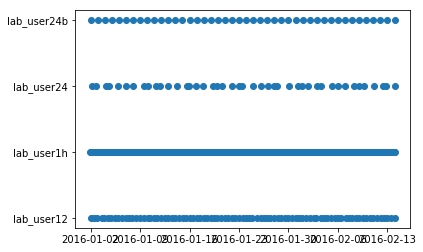

In [13]:
%matplotlib inline
plt.plot_date(all_dfs.index,all_dfs)